# 네이버 리뷰 데이터 셋 + 도서 리뷰 데이터 셋( 8점 이상 긍정 / 긍부정 리뷰 데이터 갯수 동일)

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import urllib

In [2]:
import konlpy
from konlpy.tag import Okt
from konlpy.tag import Mecab

In [3]:
okt = Okt()
sentence = "안녕하세요 저는 상휴입니다."
temp_X = okt.morphs(sentence)
temp_X

['안녕하세요', '저', '는', '상', '휴', '입니다', '.']

## [ 데이터 로드 ] 

In [4]:
# 링크로부터 훈련 데이터에 해당하는 ratings_train.txt와 테스트 데이터에 해당하는 ratings_test.txt를 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x237a9d14448>)

In [5]:
#  Pandas를 이용하여 훈련 데이터는 train_data에 테스트 데이터는 test_data에 저장

train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [6]:
# train_data에 존재하는 영화 리뷰의 개수를 확인

print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [7]:
# train_data는 어떤 형태인지 상위 5개만 출력

train_data[:5] # 상위 5개 출력

# id는 감성 분류를 수행하는데 도움이 되지 않으므로 앞으로 무시. 
# 이 모델은 리뷰 내용을 담고있는 document와 해당 리뷰가 긍정(1), 부정(0)인지를 나타내는 label 두 개의 열을 학습하는 모델
#  train_data에 대한 전처리 과정을 정하고 나면, test_data에도 동일한 전처리 과정을 적용

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## [ 데이터 정제 ]

In [8]:
#  train_data에 혹시 데이터에 중복이 있지는 않은지 확인

train_data['document'].nunique(), train_data['label'].nunique()

# 총 150,000개의 샘플이 존재하는데 document열에서 중복을 제거한 샘플의 개수가 146,182개라는 것은 약 4,000개의 중복 샘플이 존재
#  label 열은 0 또는 1의 값만을 가지므로 2가 출력

(146182, 2)

In [9]:
# 중복 샘플을 제거
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

In [10]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


<AxesSubplot:>

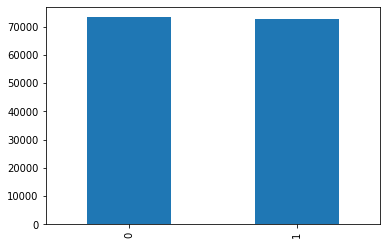

In [11]:
#  train_data에서 해당 리뷰의 긍, 부정 유무가 기재되어있는 레이블(label) 값의 분포

train_data['label'].value_counts().plot(kind = 'bar')

# 긍정과 부정 둘 다 약 72,000개의 샘플이 존재하여 레이블의 분포가 균일

In [12]:
# 긍/부정의 정확한 갯수
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [13]:
# 리뷰 중에 Null 값을 가진 샘플이 있는지는 Pandas의 isnull().values.any()로 확인
# True가 나왔다면 데이터 중에 Null 값을 가진 샘플이 존재

print(train_data.isnull().values.any()) 

True


In [14]:
# 어떤 열에 존재하는지 확인
# document 열에서 Null 값을 가진 샘플이 총 1개가 존재

print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [15]:
#  Null 값을 가진 샘플이 어느 인덱스의 위치에 존재하는지

train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [16]:
# Null 값을 가진 샘플을 제거
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [17]:
print(len(train_data)) # 샘플의 갯수

146182


## [ 전처리 ]

 train_data와 test_data에서 온점(.)이나 ?와 같은 각종 특수문자가 사용된 것을 확인  
 train_data로부터 한글만 남기고 제거하기 위해서 정규 표현식을 사용  
   
   
 한글이 아니라 영어의 경우를 상기해보겠습니다. 영어의 알파벳들을 나타내는 정규 표현식은 [a-zA-Z]입니다. 이 정규 표현식은 영어의 소문자와 대문자들을 모두 포함하고 있는 정규 표현식으로 이를 응용하면 영어에 속하지 않는 구두점이나 특수문자를 제거할 수 있습니다. 예를 들어 알파벳과 공백을 제외하고 모두 제거하는 전처리를 수행하는 예제는 다음과 같습니다.

In [18]:
text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
re.sub(r'[^a-zA-Z ]', '', text) #알파벳과 공백을 제외하고 모두 제거

'do you expect people to read the FAQ etc and actually accept hard atheism'

같은 원리를 한국어 데이터에 적용하고 싶다면, 우선 한글을 범위 지정할 수 있는 정규 표현식을 찾아내면 되겠습니다. 우선 자음과 모음에 대한 범위를 지정해보겠습니다. 일반적으로 자음의 범위는 ㄱ ~ ㅎ, 모음의 범위는 ㅏ ~ ㅣ와 같이 지정할 수 있습니다. 해당 범위 내에 어떤 자음과 모음이 속하는지 알고 싶다면 아래의 링크를 참고하시기 바랍니다.  
  
https://www.unicode.org/charts/PDF/U3130.pdf  
ㄱ ~ ㅎ: 3131 ~ 314E  
ㅏ ~ ㅣ: 314F ~ 3163  
  
  
또한 완성형 한글의 범위는 가 ~ 힣과 같이 사용합니다. 해당 범위 내에 포함된 음절들은 아래의 링크에서 확인할 수 있습니다.  
https://www.unicode.org/charts/PDF/UAC00.pdf

In [19]:
def cleansing(text):
    # text = str(text)
    pattern = "([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+.[a-zA-Z0-9-.]+)"  # e-mail 주소 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "(http|ftp|https)://(?:[-\w.]|(?:\da-fA-F]{2}))+"  # url 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "([^ㄷㅋㅎㅜㅠ가-힣a-zA-Z0-9])+"  # 한글 자음, 모음 제거 - without 'ㄷ,ㅋ,ㅎ,ㅜ,ㅠ'
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "<[^>]*>"  # html tag 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = "[\r|\n]"  # \r, \n 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    pattern = re.compile(r"\s+")  # 이중 space 제거
    text = re.sub(pattern=pattern, repl=" ", string=text)

    return text

In [20]:
# 범위 지정을 모두 반영하여 train_data에 한글과 공백을 제외하고 모두 제거하는 정규 표현식을 수행

# train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['document'] = [cleansing(text) for text in train_data["document"]]
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


상위 5개의 샘플을 다시 출력해보았는데, 정규 표현식을 수행하자 기존의 공백. 
즉, 띄어쓰기는 유지되면서 온점과 같은 구두점 등은 제거되었습니다.  
그런데 사실 네이버 영화 리뷰는 굳이 한글이 아니라 영어, 숫자, 특수문자로도 리뷰를 업로드할 수 있습니다.   
다시 말해 기존에 한글이 없는 리뷰였다면 이제 더 이상 아무런 값도 없는 빈(empty) 값이 되었을 것입니다.   
train_data에 빈 값을 가진 행이 있다면 Null 값으로 변경하도록 하고, 다시 한 번 Null 값이 존재하는지 확인해보겠습니다.

In [21]:
# train_data에 빈 값을 가진 행이 있다면 Null 값으로 변경하도록 하고, 다시 한 번 Null 값이 존재하는지 확인
# Null 값이 391개

train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id          0
document    0
label       0
dtype: int64


In [22]:
# Null 값이 있는 행을 5개만 출력

train_data.loc[train_data.document.isnull()][:5]

,id,document,label


In [23]:
# 아무런 의미도 없는 데이터므로 제거

train_data = train_data.dropna(how = 'any')
print(len(train_data))

146182


In [24]:
# 전처리 과정

test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
# test_data['document'] = [cleansing(text) for text in test_data['document']]
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48995
ipykernel_launcher:4: FutureWarning: The default value of regex will change from True to False in a future version.


## [ 토큰화 ]

토큰화 과정에서 불용어를 제거하겠습니다.  
불용어는 정의하기 나름인데, 한국어의 조사, 접속사 등의 보편적인 불용어를 사용할 수도 있겠지만 결국 풀고자 하는 문제의 데이터를 지속 검토하면서 계속해서 추가하는 경우 또한 많습니다.  
실제 현업인 상황이라면 일반적으로 아래의 불용어보다 더 많은 불용어를 사용하기도 합니다.

In [25]:
#  불용어를 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','것','라고','에게','라면','게']

Okt는 위와 같이 KoNLPy에서 제공하는 형태소 분석기입니다.  
한국어을 토큰화할 때는 영어처럼 띄어쓰기 기준으로 토큰화를 하는 것이 아니라, 주로 형태소 분석기를 사용한다고 언급한 바 있습니다  
stem = True를 사용하면 일정 수준의 정규화를 수행해주는데, 예를 들어 위의 예제의 결과를 보면 '이런'이 '이렇다'로 변환되었고 '만드는'이 '만들다'로 변환된 것을 알 수 있습니다.

In [26]:
okt = Okt() # koNLPy의 OKt
# mecab = Mecab()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True) #  stem=True : 원형 글자로 바꿔준다. (기본값 False)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [28]:
# Mecab 사용
# train_data에 형태소 분석기를 사용하여 토큰화를 하면서 불용어를 제거하여 X_train에 저장


X_train = []
for sentence in train_data['document']:
    temp_X = []
    # temp_X = mecab.morphs(sentence) # 토큰화
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [29]:
# 상위 3개의 샘플만 출력

# 형태소 토큰화가 진행

print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [30]:
print(len(X_train))

146182


In [31]:
# 테스트 데이터를 네이버 리뷰로 사용할 때 사용!!!!!!!!!!!!!!!
# 테스트 데이터에 대해서도 동일하게 토큰화

X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    # temp_X = mecab.morphs(sentence) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [136]:
print(len(test_data[(test_data['label']==1)]))
print(len(test_data[(test_data['label']==0)]))

24630
24365


In [45]:
print(len(X_test))

48995


----
# 도서 리뷰 추가

In [91]:
import glob
import pandas as pd
from pandas.core.dtypes.missing import notnull
import nltk
from konlpy.tag import Okt
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import re
from gensim.models import Word2Vec
from pandas import DataFrame
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [47]:
import os,sys
from google.colab import drive
drive.mount('/content/mnt') 
nb_path = '/content/notebooks' 
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)

Mounted at /content/mnt


In [49]:
filename_list = glob.glob('/content/mnt/My Drive/Colab Notebooks/월간베스트결과/*.csv')
print(filename_list)
print(len(filename_list))

['/content/mnt/My Drive/Colab Notebooks/월간베스트결과/결과_월간베스트_건강_취미_레저_2021년3월_20210310.csv', '/content/mnt/My Drive/Colab Notebooks/월간베스트결과/결과_월간베스트_가정_요리_뷰티_2021년3월_20210310.csv', '/content/mnt/My Drive/Colab Notebooks/월간베스트결과/결과_월간베스트_유아_2021년3월_20210310.csv', '/content/mnt/My Drive/Colab Notebooks/월간베스트결과/결과_월간베스트_인문학_2021년3월_20210310.csv', '/content/mnt/My Drive/Colab Notebooks/월간베스트결과/결과_월간베스트_자기계발_2021년3월_20210310.csv', '/content/mnt/My Drive/Colab Notebooks/월간베스트결과/결과_월간베스트_종교_역학_2021년3월_20210310.csv', '/content/mnt/My Drive/Colab Notebooks/월간베스트결과/결과_월간베스트_중학교참고서_2021년3월_20210310.csv', '/content/mnt/My Drive/Colab Notebooks/월간베스트결과/결과_월간베스트_사회과학_2021년3월_20210310.csv', '/content/mnt/My Drive/Colab Notebooks/월간베스트결과/결과_월간베스트_국내도서_2021년3월_20210310.csv', '/content/mnt/My Drive/Colab Notebooks/월간베스트결과/결과_워

In [123]:
# 데이터 합치기
book_train_data = pd.DataFrame()
for filename in filename_list:
    redf = pd.read_csv(filename, encoding="utf-8")
    # 'review' 열에 중복인 내용이 있다면 중복 제거
    redf.drop_duplicates(subset=["review"], inplace=True)
    redf = redf.dropna(how = 'any') # Null 값이 존재하는 행 제거
    # 정규 표현식을 통한 한글 외 문자 제거
    redf["review"] = [cleansing(text) for text in redf["review"]]
    redf = redf.dropna(how = 'any') # Null 값이 존재하는 행 제거
    redf["label"] = [1 if rat > 7 else 0 for rat in redf["rating"]]
#     print(redf.head())
    book_train_data = pd.concat([book_train_data,redf])

In [51]:
# 코드 확인
print(book_train_data.head())
print(len(book_train_data))

          ISBN13  rating                               review  label
0  9791160075793      10                           벵감님 행복하시죠       1
1  9791160075793      10   merciArsene감독님 꽃이 지고나서야 봄인줄 알았습니다       1
2  9791160075793      10       20년차 맹구지만 벵버지라 구매하려 합니다 그립읍니다       1
3  9791160075793      10                        벵버지 이제야 깨달아요       1
4  9791160075793      10               선 5점 후 책 수령 벵감님 그립습니다       1
143383


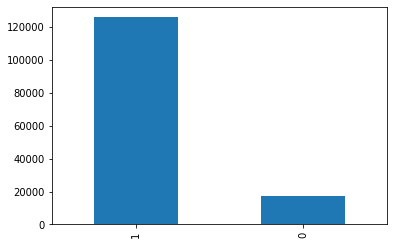

In [52]:
book_train_data['label'].value_counts().plot(kind = 'bar')

In [53]:
# 긍/부정의 정확한 갯수
print(book_train_data.groupby('label').size().reset_index(name = 'count'))

   label   count
0      0   17430
1      1  125953


In [54]:

# book_train_data[(book_train_data['label']==0)]
neg_len = len(book_train_data[(book_train_data['label']==0)])
print(neg_len)
pos = book_train_data[(book_train_data['label']==1)][0:neg_len]
neg = book_train_data[(book_train_data['label']==0)][0:neg_len]
# print(pos.head())
print(pos)
print(neg)

# pos neg 비율 일치하는 train 데이터
book_pos_neg_train_data = pd.DataFrame()
book_pos_neg_train_data = pd.concat([pos,neg])

print(len(book_pos_neg_train_data))

17430
             ISBN13  ...  label
0     9791160075793  ...      1
1     9791160075793  ...      1
2     9791160075793  ...      1
3     9791160075793  ...      1
4     9791160075793  ...      1
...             ...  ...    ...
5141  9788964358290  ...      1
5142  9788964358290  ...      1
5143  9788964358290  ...      1
5145  9788964358290  ...      1
5146  9788964358290  ...      1

[17430 rows x 4 columns]
             ISBN13  ...  label
88    9791196834005  ...      0
113   9791196870553  ...      0
134   9788960518025  ...      0
140   9788960518025  ...      0
174   9788992141338  ...      0
...             ...  ...    ...
4650  9788971998427  ...      0
4659  9791158883270  ...      0
4717  9791186900444  ...      0
4718  9791186900444  ...      0
4723  9788936452247  ...      0

[17430 rows x 4 columns]
34860


In [60]:
#  도서 불용어를 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다',
             '것','라고','에게','라면','게','을','이라','라니','있다','아','랑','쯤된','에서','에선','어','이지만','으로나','때','때는','때라면','때라서','라','이다','있',
             '죠','고','니','로','있','같','어서','어요','는데','습니다','면서']


In [125]:
# 도서 train 데이터 토큰화
print(len(X_train))

book_train_temp_X = []
for sentence in book_pos_neg_train_data['review']:
    temp_X = []
    # temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = mecab.morphs(sentence) # mecab 사용
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    print(temp_X)
    X_train.append(temp_X)
    book_train_temp_X.append(temp_X)
print('END')
print(book_train_temp_X[:100])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
['초보', '보', '기', '너무', '어렵', '2', '장', '채권', '편', '읽', '다', '보', '면', '책', '끝', '까지', '다', '읽', '수', '을까', '하', '생각', '듭니다']
['채권', '식', '주식', '실제', '분석', '예시', '많', '지', '않', '아쉽', '다']
['표현', '유명', '어떤', '책', '이랑', '넘', '비슷', '거', '다']
['그냥', '그래요', '읽', '만', '페이지', '만', '몇', '장', '보', '꽂', '둠']
['가치', '평가', '법', '대한', '저자', '개인', '로직', '공식', '화', '하', '여', '쉽', '설명', '하', '경제', '적', '해자', '관한', '내용', '요약', '정리', '하', '여', '설명', '합니다', '투자', '대한', '선택', '장애', '으신', '분', '특히', '도움', '될', '만', '책', '생각', '하', '며', '일독', '권합니다']
['책', '내용', '정말', '좋', '은데', '번역', '아주', '엉망', '입니다']
['올드', '뉴', '나누', '그런', '이름', '붙인', '부터', '진부', '하', '다', '차라리', '뉴', '대해서', '만', '이야기', '하', '지', '그랬', '나']
['근래', '나온', '책', '많이', '읽', '으신', '분', '비추', '다른', '작가', '생각', '짜집기', '수준', '입니다', '작가', '주장', '사례', '이해', '할', '수', '없', '네요', '출판사', '제공', '책', '소개', '만', '읽', '어도', '충분', '하', '네요']
['빅', '데이터', '대한', '전반', '적', '인', '지식', '전달', '해', '주', '설명문', '그', '이상', '그', 

In [126]:
print(len(X_train))
print(len(book_train_temp_X))

180886
34860


In [110]:
# 네이버 리뷰 토큰화 + 도서 train 토큰화
# X_train.append(book_train_temp_X)
print(len(X_train))

180886


----

### 도서 리뷰로 테스트 데이터 셋 만들기

In [66]:
# 트레이닝 데이터에 쓰인 도서 리스트
# print(book_train_data['ISBN13'])

# 전부 다 쓸 때
# book_train_set = set([])

# for i in range(0, len(book_train_data)):
#   book_train_set.add(book_train_data.iloc[i]['ISBN13'])

# print(len(book_train_set))
# print(book_train_set)

# 긍부정 비율 맞춰서 쓸 때
book_train_set = set([])

for i in range(0, len(book_pos_neg_train_data)):
  book_train_set.add(book_pos_neg_train_data.iloc[i]['ISBN13'])

print(len(book_train_set))
print(book_train_set)

5495
{9791165792268, 9791165792282, 9788995797020, 9791191187533, 9788959195213, 9788959522897, 9791191056471, 9788957360217, 9788991799400, 9791191187564, 9791196889203, 9788901064819, 9791191122039, 9788947529877, 9788932030616, 9788911124640, 9788927770787, 9788957360293, 9791163629733, 9791163400363, 9788926001325, 9788935700660, 9788991799479, 9788960178359, 9788936454333, 9791160320190, 9788952117441, 9788962472134, 9788926001356, 9788962472141, 9788968665295, 9788954673365, 9788926001370, 9791190991070, 9791160320237, 9791191187694, 9791130337524, 9788994158839, 9791185060088, 9788991799561, 9788926001417, 9791164842254, 9791164449040, 9791185060125, 9791186075944, 9791130632506, 9791185060156, 9791125422419, 9788978495844, 9791160320367, 9788954640756, 9788937437564, 9788983411068, 9788951101823, 9788970598826, 9788955820461, 9788934914488, 9791196922306, 9791185617350, 9791136727503, 9788954673617, 9788968665561, 9788935209439, 9788993143300, 9788932030982, 9788950970888, 9788

In [72]:
testfile_list = glob.glob('/content/mnt/My Drive/Colab Notebooks/trainData/*.csv')
print(testfile_list)
print(len(testfile_list))

['/content/mnt/My Drive/Colab Notebooks/trainData/알라딘_월간+베스트_TV_라디오_2021년3월_20210315.csv', '/content/mnt/My Drive/Colab Notebooks/trainData/알라딘_월간+베스트_건축_2021년3월_20210315.csv', '/content/mnt/My Drive/Colab Notebooks/trainData/알라딘_월간+베스트_디자인_공예_2021년3월_20210315.csv', '/content/mnt/My Drive/Colab Notebooks/trainData/알라딘_월간+베스트_무용_2021년3월_20210315.csv', '/content/mnt/My Drive/Colab Notebooks/trainData/알라딘_월간+베스트_뮤지컬_오페라_2021년3월_20210315.csv', '/content/mnt/My Drive/Colab Notebooks/trainData/알라딘_월간+베스트_미술_2021년3월_20210315.csv', '/content/mnt/My Drive/Colab Notebooks/trainData/알라딘_월간+베스트_미술_음악_예술치료_2021년3월_20210315.csv', '/content/mnt/My Drive/Colab Notebooks/trainData/알라딘_월간+베스트_사진_2021년3월_20210315.csv', '/content/mnt/My Drive/Colab Notebooks/trainData/알라딘_월간+베스트_연극_2021년3월_20210315.csv', '/content/mnt/

In [73]:
# 테스트 데이터 합치기
book_test_data = pd.DataFrame()
for filename in testfile_list:
    redf = pd.read_csv(filename, encoding="utf-8")
    redf.drop_duplicates(subset=["review"], inplace=True)
    redf = redf.dropna(how = 'any') # Null 값이 존재하는 행 제거
    # 정규 표현식을 통한 한글 외 문자 제거
    redf["review"] = [cleansing(text) for text in redf["review"]]
    redf = redf.dropna(how = 'any') # Null 값이 존재하는 행 제거
    redf["label"] = [1 if rat > 7 else 0 for rat in redf["rating"]]
#     print(redf.head())
    book_test_data = pd.concat([book_test_data,redf])

print(len(book_test_data))

178324


In [76]:
# print(book_test_data.head())
# train과 동일한 ISBN은 제거
for isbn in book_train_set :
  idx_list = book_test_data[book_test_data['ISBN13']==isbn].index
  book_test_data = book_test_data.drop(idx_list)
print(len(book_test_data))

11478


In [77]:
print(book_test_data[book_test_data['ISBN13']==9788911124640])

Empty DataFrame
Columns: [ISBN13, rating, review, label]
Index: []


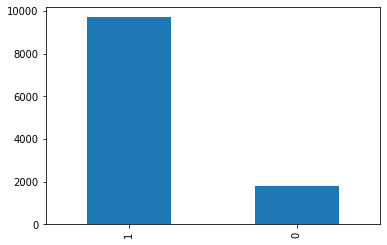

In [78]:
book_test_data['label'].value_counts().plot(kind = 'bar')

In [79]:
print(book_test_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   1783
1      1   9695


In [80]:
test_neg_len = len(book_test_data[(book_test_data['label']==0)])
print(test_neg_len)
test_pos = book_test_data[(book_test_data['label']==1)][0:test_neg_len*2]
test_neg = book_test_data[(book_test_data['label']==0)][0:test_neg_len]
# print(pos.head())
# print(test_pos)
# print(test_neg)

# pos neg 비율 일치하는 train 데이터
book_pos_neg_test_data = pd.DataFrame()
book_pos_neg_test_data = pd.concat([test_pos,test_neg])

print(len(book_pos_neg_test_data))

1783
3566


In [137]:
# 네이버 리뷰 토큰화 한거에 도서 리뷰 토근화한거 합치기 - 테스트용
print(len(X_test))

book_X_test = []
for sentence in book_pos_neg_test_data['review']:
  temp_X = []
  # temp_X = okt.morphs(sentence, stem=True) # 토큰화
  temp_X = mecab.morphs(sentence)
  temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
  X_test.append(temp_X)
  book_X_test.append(temp_X)
print(book_X_test[:10])

48995
[['짧', '간단', '이야기', '지만', '엄마', '아가', '일상', '모습', '아닐까'], ['간단', '이야기', '그렇지만', '정곡', '찌르', '재밌', '이야기', '굿'], ['7', '살', '짜리', '아들', '구매', '해', '주', '5', '살', '짜리', '조카', '선물', '해', '주', '었', '답니다', '강추', '합니다'], ['마음', '아려', '오', '따뜻', '해', '지', '훈훈', '해', '지', '마치', '겨울', '밤', '따뜻', '코코아', '마시', '듯', '기분'], ['홀로', '서기', '하', '우리', '아이', '용기', '주', '친구', '사귀', '법', '알려', '주', '멋진', '그림책', '에요', '눈', '내려요'], ['글', '밥', '많', '편의', '동화책', '고학년', '딸애', '재미있', '읽', '네요', '그림', '예뻐서', '소장', '용', '좋', '네요', '따뜻', '함', '느껴', '지', '동화', '입니다'], ['강풀', '작가', '팬', '라서', '설레', '맘', '주문', '하', '아들', '함께', '읽', '었', '아이', '되', '었', '다가', '고양이', '되', '었', '다가', '감정', '입', '되', '빨려', '들어갔', '구요', '여덟', '살', '아들', '너무', '즐거워', '하', '며', '읽', '었', '네요', '그림', '너무', '따뜻', '해요'], ['그림', '예쁘', '내용', '따뜻', '하', '울', '딸', '선물', '합니다'], ['강풀', '작가', '그림책', '무척', '궁금', '하', '다'], ['파닉스', '시작', '했', '다면', '꼭', '같이', '병행', '하', '추천', '하', '책', '입니다', '단순', '하', '쉽', '구성', '되', '지만', '꼭', '필요', '사이트', '워드

In [138]:
# X_test.append(book_X_test)
print(len(X_test))

52561


## [정수 인코딩]

기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다.  
우선, 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어봅시다.

In [127]:
#  단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

각 정수는 전체 훈련 데이터에서 등장 빈도수가 높은 순서대로 부여되었기 때문에, 높은 정수가 부여된 단어들은 등장 빈도수가 매우 낮다는 것을 의미.

In [128]:
print(tokenizer.word_index)

{'다': 1, '하': 2, '영화': 3, '보': 4, '지': 5, '좋': 6, '책': 7, '없': 8, '었': 9, '나': 10, '만': 11, '적': 12, '네요': 13, '너무': 14, '기': 15, '수': 16, '되': 17, '지만': 18, '했': 19, '안': 20, '않': 21, '정말': 22, '봤': 23, '았': 24, '음': 25, '인': 26, '면': 27, '읽': 28, '주': 29, '거': 30, '재밌': 31, '할': 32, '해': 33, '말': 34, '진짜': 35, '생각': 36, '싶': 37, '점': 38, '던': 39, '내': 40, '네': 41, '겠': 42, '내용': 43, '더': 44, '사람': 45, '그': 46, '듯': 47, '아니': 48, '이런': 49, '연기': 50, '최고': 51, '알': 52, '왜': 53, '까지': 54, '평점': 55, '만들': 56, '보다': 57, '함': 58, '스토리': 59, '많': 60, '볼': 61, '입니다': 62, '드라마': 63, '감동': 64, '재미있': 65, '중': 66, '아이': 67, '본': 68, '해서': 69, '서': 70, '그냥': 71, '배우': 72, '기대': 73, '재미': 74, '시간': 75, '뭐': 76, '번': 77, '사랑': 78, '년': 79, '지루': 80, '합니다': 81, '라는': 82, '못': 83, '였': 84, '다는': 85, '감독': 86, '아요': 87, '이야기': 88, '하나': 89, '다시': 90, '줄': 91, '작품': 92, '님': 93, '정도': 94, '느낌': 95, '나오': 96, '된': 97, '으면': 98, '잼': 99, '시': 100, '분': 101, '냐': 102, '많이': 103, '건': 104, '재미없': 105, '야'

여기서는 빈도수가 낮은 단어들은 자연어 처리에서 배제하고자 합니다.  
등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

In [129]:
# 여기서는 빈도수가 낮은 단어들은 자연어 처리에서 배제하고자 합니다. 
# 등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value

  # 단어의 등장 빈도수가 threshold보다 작으면
  if(value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 56408
등장 빈도가 2번 이하인 희귀 단어의 수: 29093
단어 집합에서 희귀 단어의 비율: 51.576017586157995
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.4485861567361358


In [130]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 27317


In [139]:
# 케라스 토크나이저의 인자로 넘겨주면, 케라스 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환합니다. 
# 이러한 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환하겠습니다. 
# 다시 말해 정수 1번으로 할당합니다. (정수 인코딩 챕터 참고!)

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [140]:
print(X_train[:3])

[[45, 1186, 36, 238, 11, 14, 804], [1058, 615, 610, 817, 4, 92, 1944, 51, 904, 644, 6, 22, 370], [15, 204, 1]]


In [142]:
# y_train1 = np.array(train_data['label'])
# y_train2 = np.array(book_train_data['label'])

# y_train = np.r_[y_train1,y_train2]
# y_test = np.array(test_data['label'])


###
y_train1 = np.array(train_data['label'])
y_pos = np.array(pos['label'])
y_neg = np.array(neg['lebel'])
y_pos_neg = np.r_[y_pos,y_neg]

y_train = np.r_[y_train1,y_pos_neg]



y_test1 = np.array(test_data['label'])

y_test_pos = np.array(test_pos['label'])
y_test_neg = np.array(test_neg['lebel'])
y_test_pos_neg = np.r_[y_test_pos,y_test_neg]

y_test = np.r_[y_test1,y_test_pos_neg]

KeyError: ignored

In [141]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

180886


NameError: ignored

In [ ]:
# print(len(y_train))
# print(y_train)

# print(len(y_train2))
# print(y_train2)

# print(len(y_train)+len(y_train2))

# print(len(train_data))
# print(len(book_train_data))
# print(len(train_data)+len(book_train_data))

# print('\n')
print(len(y_train))

287859


## 5) 빈 샘플(empty samples) 제거

In [ ]:
# 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 
# 이제 빈(empty) 샘플이 되었다는 것을 의미

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

287805
287805


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## 6) 패딩


리뷰의 최대 길이 : 1273
리뷰의 평균 길이 : 15.718517746390786


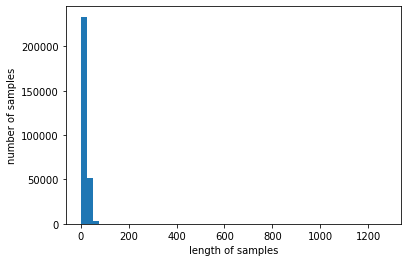

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 60 # 도서리뷰 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.88742377651535


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
print(len(X_train))
print(len(y_train))

287805
287805


# 2. LSTM으로 리뷰 감성 분류하기

In [ ]:
import tensorflow
import keras
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# 임베딩 벡터의 차원은 100
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
path = '/content/mnt/My Drive/Colab Notebooks/'
mc = ModelCheckpoint(path+'best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
print(len(X_train))
print(len(y_train))

print(X_train[:5])
print(y_train[:5])

287805
287805
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0    94  1163    50   634   918]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0  1441  1019    51  1373     6   205  2476    98  1207   371    18]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0   

In [ ]:
# 에포크는 총 15번을 수행
# 훈련 데이터 중 20%를 검증 데이터로 사용하면서 정확도를 확인
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
3838/3838 [==============================] - 576s 150ms/step - loss: 0.3812 - acc: 0.8352 - val_loss: 0.4782 - val_acc: 0.7853

Epoch 00001: val_acc improved from -inf to 0.78525, saving model to /content/mnt/My Drive/Colab Notebooks/best_model.h5
Epoch 2/15
3838/3838 [==============================] - 580s 151ms/step - loss: 0.3595 - acc: 0.8461 - val_loss: 0.4814 - val_acc: 0.7855

Epoch 00002: val_acc improved from 0.78525 to 0.78555, saving model to /content/mnt/My Drive/Colab Notebooks/best_model.h5
Epoch 3/15
3838/3838 [==============================] - 580s 151ms/step - loss: 0.3437 - acc: 0.8538 - val_loss: 0.4789 - val_acc: 0.7839

Epoch 00003: val_acc did not improve from 0.78555
Epoch 4/15
3838/3838 [==============================] - 579s 151ms/step - loss: 0.3230 - acc: 0.8651 - val_loss: 0.4907 - val_acc: 0.7789

Epoch 00004: val_acc did not improve from 0.78555
Epoch 5/15
3838/3838 [==============================] - 583s 152ms/step - loss: 0.3063 - acc: 0.8731 

In [ ]:
path = '/content/mnt/My Drive/Colab Notebooks/'
loaded_model = load_model(path+'best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1514/1514 [==============================] - 33s 21ms/step - loss: 0.3359 - acc: 0.8547

 테스트 정확도: 0.8547


# 3. 리뷰 예측해보기


In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

# 도서 리뷰에 적용

In [ ]:
book = pd.read_csv(r"/content/mnt/My Drive/Colab Notebooks/월간베스트결과/결과_월간베스트_국내도서_2021년3월_20210310.csv", encoding="utf-8")
target_isbn = 9788936434267
tmp = book[book["ISBN13"] == target_isbn].dropna(how="any")
tmp = tmp.dropna(how="any")  # Null 값이 존재하는 행 제거

for i in range(0, len(tmp.index)):
    print(tmp.iloc[i]['rating'])
    print(tmp.iloc[i]["review"])
    sentiment_predict(tmp.iloc[i]["review"])

10
읽기 시작하면 다음 내용 궁금해서 멈출 수가 없네요 재밌는 소설 알게 돼서 좋아요
92.03% 확률로 긍정 리뷰입니다.

10
명작이에요 어릴적 생각도나고제 어릴적 상황이랑 너무 닮아있어서똑같았던 상황이 많아서..주인공이 놓여있는 상황을 불쌍하게 일반적이지 않게 풀어낸게 아니라그냥 일반적인 평범하게 느끼는게 당연하다고담담하게 일상으로 풀어나가는것 좋았어요
95.76% 확률로 긍정 리뷰입니다.

10
이 글의 주인공은 윤재가 아니라 곤이라고 생각함.
53.70% 확률로 부정 리뷰입니다.

8
이 사회에서는 평범한 성장도 괴물이되고 약자가 된다.인간은 다양한 만남에서 성장한다는 것을 아이들이 말해준다. 똑같은 아파트에서 평수만을 논하는 어른들에게 자란 아이들이야말로 괴물이다. 사춘기 아이들과 그 부모가 읽어야할 성장기. 다소 유치한 대화 등이 조금 아쉬움
51.51% 확률로 긍정 리뷰입니다.

4
빌려서 볼만한 책 그다지 기억에 남지 않음.... 중간부터 지루해서 빨리 읽었다. 여자 캐릭터와 뜬금없는 스킨십.... 문장이 웹소설같다
98.59% 확률로 부정 리뷰입니다.

10
담담한 문체 속에 빨려 들어갔습니다.
59.61% 확률로 긍정 리뷰입니다.

10
너무나 사랑하는 곤이에게 자두맛 사탕을 주고 싶다
91.51% 확률로 긍정 리뷰입니다.

10
주말동안 할일 다 제쳐놓고 읽었다. 쓴 현실에 공감도 많이 되면서 누구도 선인 혹은 악인이라고 정의내릴수없다는 생각을 하게한다
86.86% 확률로 긍정 리뷰입니다.

2
재미도 없고 감동도 없고 여운도 없고 그냥 너무 별로였어요..
99.37% 확률로 부정 리뷰입니다.

6
중학교 1학년때 읽고 나선 재밌다? 이런 느낌이었는데 3년이 흐른 후 이 책을 다시 떠올리면 그동안 읽었던 책들에 비해 그리 재밌진 않았다고 느껴지네요,, 무슨 내용이었는지 기억도 안날만큼 임팩트가 없어요
70.39% 확률로 부정 리뷰입니다.

6
저는 큰 감흥 없었지만..10대들이 읽으면 재밌겠네요. 소설에 익숙한 성인들이 읽기에는 당연히 